0    Items are occasionally getting stuck in the sc...
1    Loud rattling and banging sounds are coming fr...
2    There are cuts to the power when starting the ...
3                   Fried capacitors in the assembler.
4                             Mixer tripped the fuses.
Name: Description, dtype: object


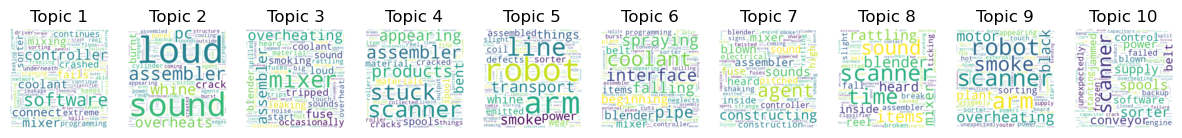

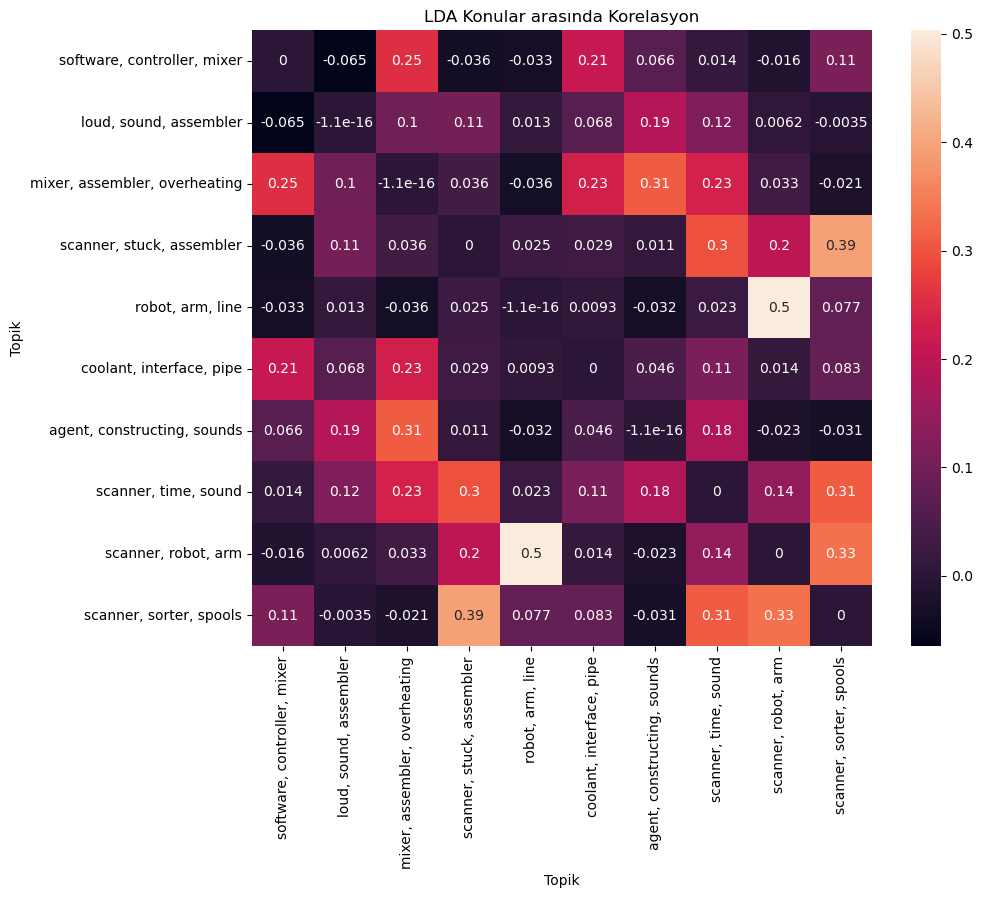

   TopikIndex                          Topik  \
0           1    software, controller, mixer   
1           2         loud, sound, assembler   
2           3  mixer, assembler, overheating   
3           4      scanner, stuck, assembler   
4           5               robot, arm, line   
5           6       coolant, interface, pipe   
6           7    agent, constructing, sounds   
7           8           scanner, time, sound   
8           9            scanner, robot, arm   
9          10        scanner, sorter, spools   

   Korelasyonun yüksek olduğu topik indexler  \
0                                          3   
1                                          7   
2                                          7   
3                                         10   
4                                          9   
5                                          3   
6                                          3   
7                                         10   
8                                      

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation
from wordcloud import WordCloud
import seaborn as sns

# Veriyi oku
filename = "factoryReports.csv"
data = pd.read_csv(filename)
textData = data["Description"]
print(textData.head())

# Metin verilerini ön işle
def preprocess_text(text_data):
    clean_text_data = text_data.str.lower()
    documents = clean_text_data.str.replace('[^\w\s]', '').str.split()
    documents = documents.apply(lambda x: ' '.join([word for word in x]))
    return documents

documents = preprocess_text(textData)

# Bag of Words modeli oluştur
vectorizer = CountVectorizer(stop_words='english', max_df=0.85)
X = vectorizer.fit_transform(documents)

# LDA modelini oluştur
num_topics = 10
lda = LatentDirichletAllocation(n_components=num_topics, random_state=42)
lda.fit(X)

# Kelime bulutları oluştur
def plot_wordcloud(lda_model, feature_names, num_topics):
    plt.figure(figsize=(15, 10))
    for i in range(num_topics):
        plt.subplot(1, num_topics, i+1)
        wordcloud = WordCloud(width=400, height=400, background_color="white").generate_from_frequencies(dict(zip(feature_names, lda_model.components_[i])))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.title(f"Topic {i + 1}")

feature_names = vectorizer.get_feature_names_out()
plot_wordcloud(lda, feature_names, num_topics)
plt.show()

# Konu korelasyonları
correlation = np.corrcoef(lda.components_)
num_topics = lda.n_components

# Konu korelasyon ısı haritası
top_words = [', '.join(vectorizer.get_feature_names_out()[i] for i in np.argsort(lda.components_[j])[::-1][:3]) for j in range(num_topics)]
plt.figure(figsize=(10, 8))
sns.heatmap(correlation - np.eye(num_topics), xticklabels=top_words, yticklabels=top_words, annot=True)
plt.title("LDA Konular arasında Korelasyon")
plt.xlabel("Topik")
plt.ylabel("Topik")
plt.show()

# En çok korele olan konuları bul
top_correlations = np.max(correlation - np.eye(num_topics), axis=1)
top_correlated_topics = np.argmax(correlation - np.eye(num_topics), axis=1) + 1

tbl = pd.DataFrame({
    "TopikIndex": np.arange(1, num_topics + 1),
    "Topik": top_words,
    "Korelasyonun yüksek olduğu topik indexler": top_correlated_topics,
    "Korelasyonun yüksek olduğu topikler": [top_words[i - 1] for i in top_correlated_topics],
    "Korelasyon Katsayısı": top_correlations
})

print(tbl)
